In [1]:
library("IRdisplay")
display_html('<style> h1,h2,h3,h4,h5,h6 {text-align:center}</style>')

## Exploration visuelle des données

Ce projet est un travail sur données réelles. Il s'agit de mettre en œuvre les méthodes vues en
cours sur plusieurs jeux de données proposés (pomeroy, gordon).
Le projet doit suivre les étapes suivantes :
- analyser le jeu de données proposé afin de choisir l’approche la plus adaptée à votre
problème,
- effectuer un prétraitement de votre base de données (si nécessaire),
- tester les approches choisies sur les ensembles de données en utilisant les options vues
en cours,
- analyser et commenter les résultats obtenus.

In [2]:
libraryPlus=function(p){ if(!require(p,character.only = T)){install.packages(p,character.only = T)}; library(p,character.only = T)}
librariesPlus=function(...){for(i in list(...)){libraryPlus(i)}}
librariesPlus(
    "FactoMineR",
    "factoextra",
    "dimRed",
    "lle",
    "Rtsne",
    "igraph",
    "TSclust",
    "vegan",
    "ade4",
    "MASS",
    "ggplot2",
    "gridExtra",
    "dplyr",
    "tidyverse",
    'caret',
    "virtualspecies",
    "devtools",
    "mctest",
    "memisc",
    "kohonen",
    "ggrepel",
    "mclust",
    "corrplot")

if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
if(!require("RDRToolbox")) BiocManager::install("RDRToolbox", version = "3.8")
library("RDRToolbox")
#install.packages("devtools")
#options(unzip = "internal")
#install_github("Displayr/flipMultivariates")library(mctest)



### Analyse sur Pomeroy

In [3]:
rawdata = read.csv2("pomeroy-2002-v2_database.txt",sep="\t",header = T,row.names = 1)
data = read.csv2("pomeroy-2002-v2_database.txt",sep="\t",header = F,row.names = 1,skip = 2)
classes =read.csv2("pomeroy-2002-v2_database.txt",sep="\t",header = T,nrows = 1)[-1]
classes=t(classes)
data=t(data)
data=data.frame(classes,data,row.names = colnames(raw))
data_raw = scale(data[,-1],center = TRUE,scale = TRUE)                
data_labels=data[,1]
train.label = as.factor(data_labels)
colors = rainbow(length(unique(train.label)))

Warning message in if (!header) rlabp <- FALSE:
"la condition a une longueur > 1 et seul le premier élément est utilisé"Warning message in if (header) {:
"la condition a une longueur > 1 et seul le premier élément est utilisé"

In [4]:
dim(data)

[1]   42 1379

In [5]:
unique(data_labels)

[1] MD    Mglio Rhab  Ncer  PNET 
Levels: MD Mglio Ncer PNET Rhab

In [6]:
table(data_labels)

data_labels
   MD Mglio  Ncer  PNET  Rhab 
   10    10     4     8    10 

####  PCA

In [7]:
res.pca.poomeroy = FactoMineR::PCA(data_raw,scale.unit = FALSE,ncp = 34)

##### Valeur Propre

On va voir s'il y des composantes qui n'apporte pas d'information au vue de la variance (eigenValue< 1) 

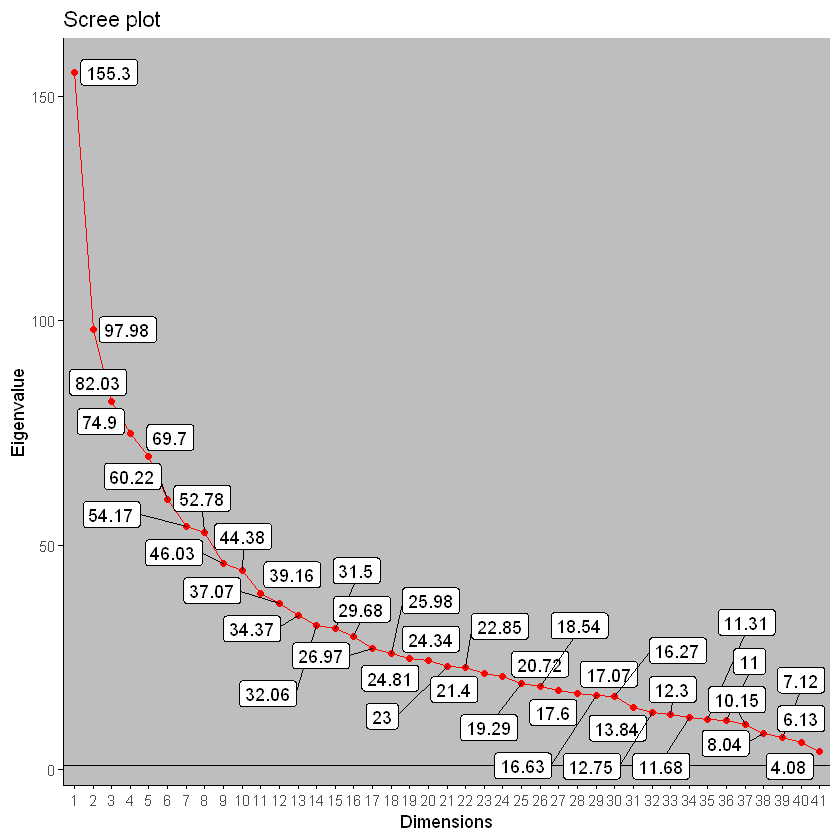

In [8]:
fviz_eig(res.pca.poomeroy,addlabels = FALSE,choice = "eigenvalue",ncp = Inf,geom = c("line"), linecolor = "red",ggtheme = theme(panel.background = element_rect(fill = 'grey', size = 1),panel.grid.major = element_blank(),panel.grid.minor = element_blank(),axis.line = element_line(size = 0.1, linetype = "solid",colour = "black"))) + geom_abline(slope=0,intercept = 1) + geom_label_repel(aes(label=round(res.pca.poomeroy$eig[,"eigenvalue"],2))) 

95% de l'information est contenu dans les 34 composantes principales

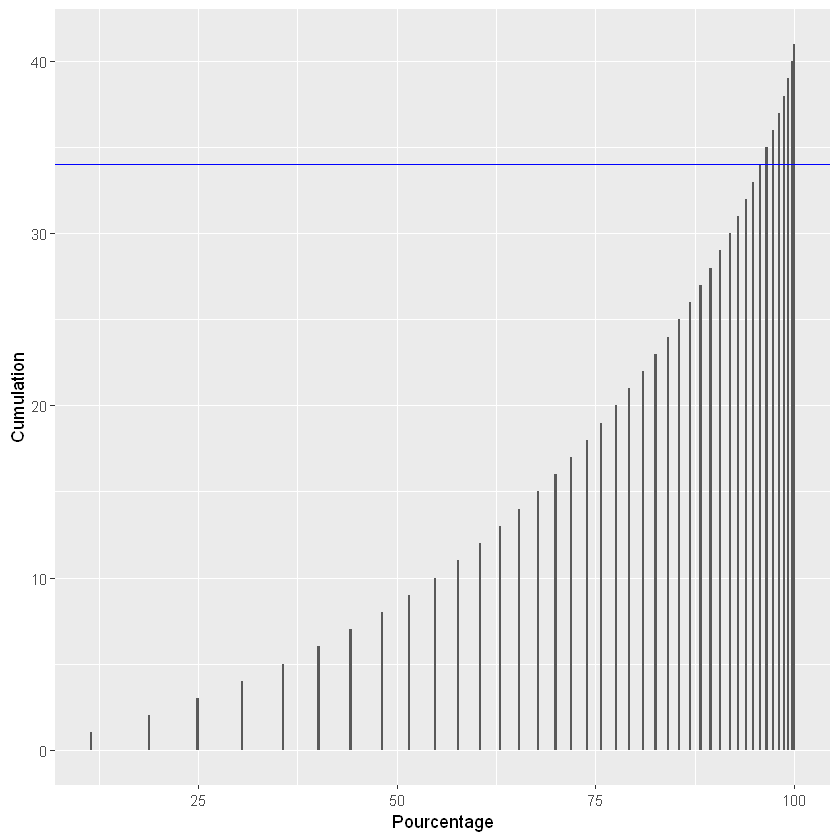

In [9]:
data.frame(Pourcentage=res.pca.poomeroy$eig[,3],Cumulation=1:41) %>% ggplot(aes(x=Pourcentage,y=Cumulation)) + geom_bar(stat = "identity") + geom_hline(yintercept = 34,color="blue")

In [10]:
# La somme est nulle
print(sum(res.pca.poomeroy$eig[,"eigenvalue"] < 1))

[1] 0


Toutes les composantes principales apporte de l'information

### Plan Factoriel des individus

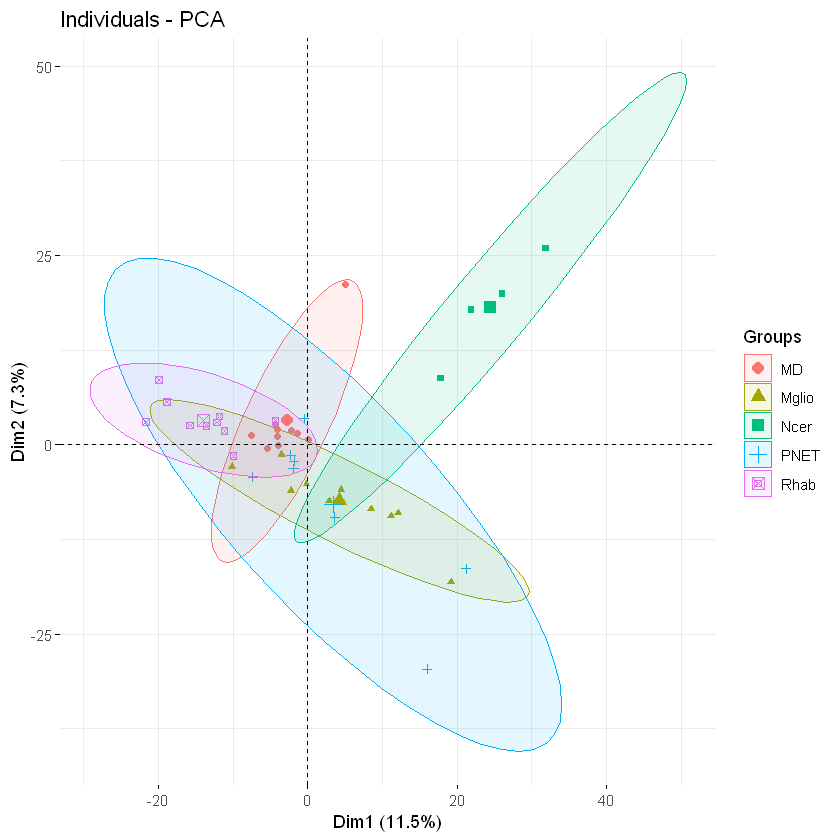

In [11]:
fviz_pca_ind(res.pca.poomeroy,
             geom.ind = "point", # Montre les points seulement (mais pas le "text")
             col.ind = classes, # colorer by groups
             #palette = c("#00AFBB", "#E7B800", "#FC4E07","#f698db","#322c61","#1d2e36"),
             addEllipses = TRUE, # Ellipses de concentration
             legend.title = "Groups"
             )

on vois que le groupe Ncer est assez bien séparé des autre individus, plutot assez positifs sur le premiere axe et moyen haut sur le deuxieme<br>
On vois que le groupe Rhab  est plutot moyen bas sur le premiere axe, et moyen sur le deuxieme <br>
On vois que le groupe Mglio est plutot moyen bas sur le deuxieme axes<br>
on vois que le groupe Md est plutot moyen haut sur le deuxieme axes, et plutot moyen bas sur le premiere axes, -> plutot moyen du coups<br>
On vois  que Pnet est pluto moyen bas sur le deuxieme axes

###  Cercle de correlation des variables

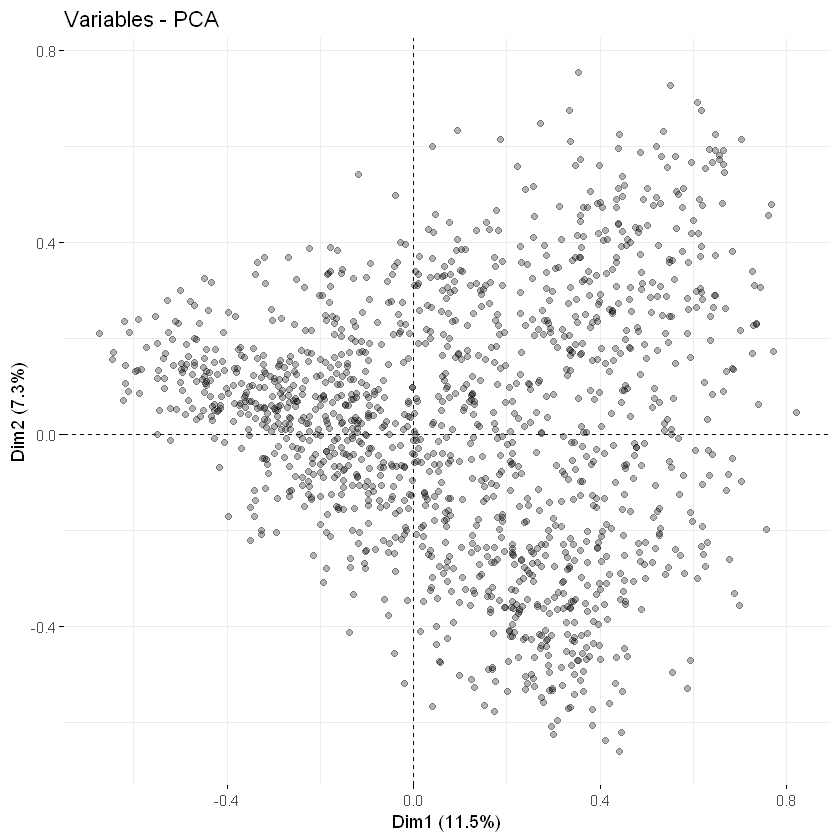

In [12]:
fviz_pca_var(res.pca.poomeroy, labels=F,geom = "point",alpha=0.3)

On voit que beaucoup de variable sont moyen bas sur le premiere axe, et moyen haut sur le deuxieme <br>
On voit qu'il ya aussi des individus dispersés en bas a droite</b>

Je choisis de prendre que les variable 'bien' projeté  > 0.8

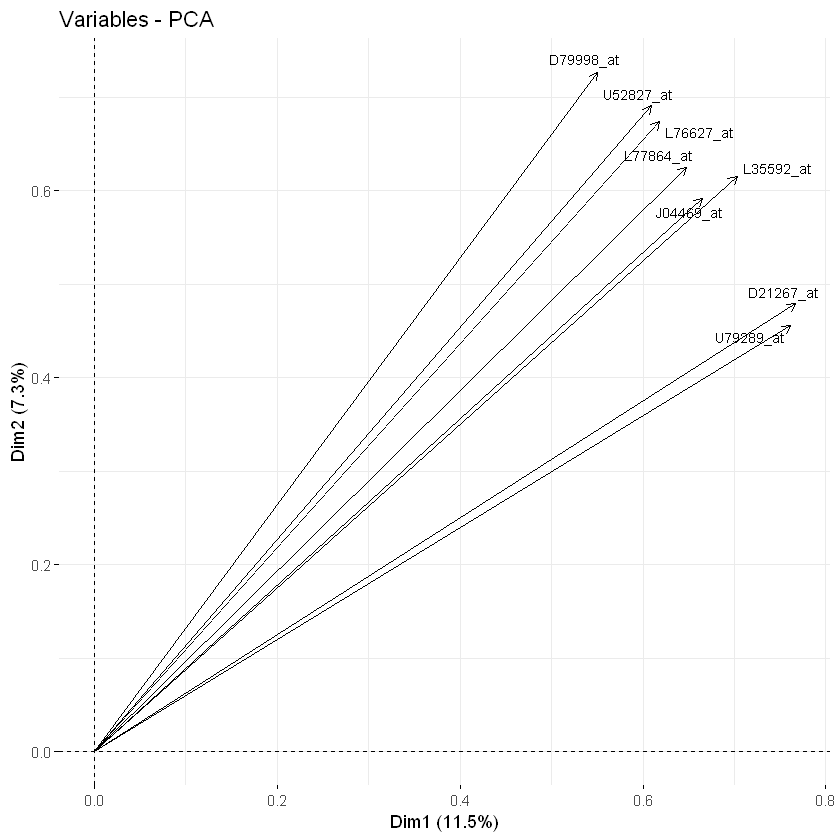

In [13]:
# Cercle de corrélation
fviz_pca_var(res.pca.poomeroy, select.var = list(cos2=0.8), repel=T,labelsize=3)

Sur les deux premier axes ont a presque 19% ce que est bcp au vus des 1380 variables et 42 composantes principales.

In [14]:
dl=apply(res.pca.poomeroy$var$cos2[,c(1,2)],1,sum)

In [15]:
names_0.8 = names(dl[dl>0.8])

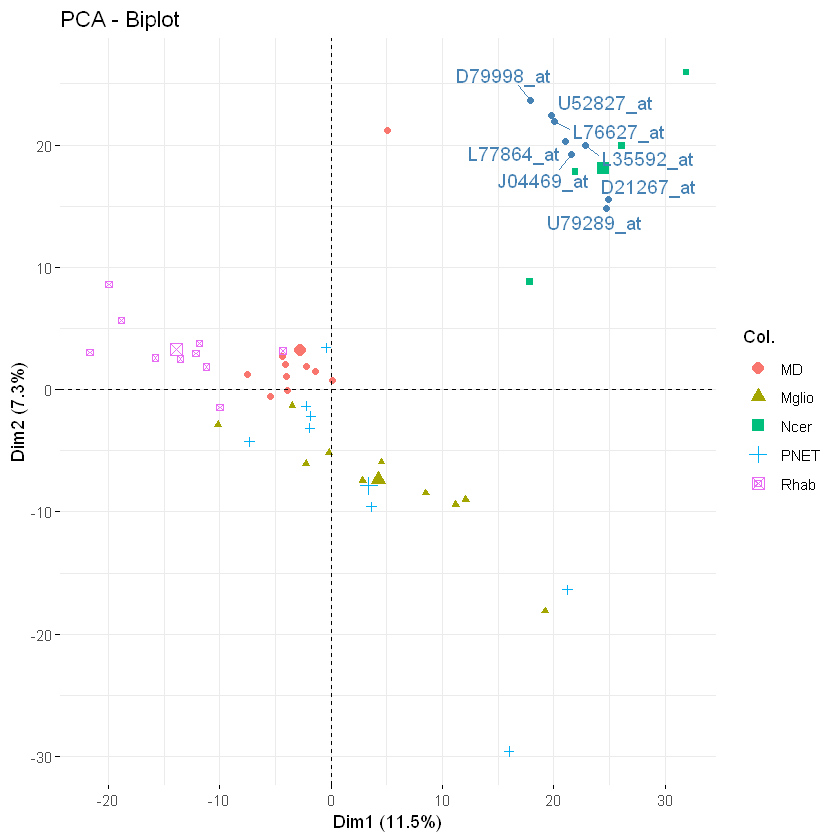

In [16]:
fviz_pca_biplot(res.pca.poomeroy,
                select.var=list(cos2=0.8),
                geom.ind = c("point"),
                geom.var = c("point","text"),
                repel=T,
                col.ind = classes)

Ncer est donc caracterisé par D21267_at fort et D79998_at fort <br>
Rhab c'est l'inverse quand D21267_at est faible et D79998_at moyen <br>
Md c'est moyen  quasimment au centre D21267_at et D79998_at moyen <br>
Mglio pluot  D21267_at moyen est D79998_at bat <br>
Pnet plutot D79998_at bat

#####  LDA

On sait les classes, et on cherche a minimiser l'inertie intra et  maximiser l'inter  des classes

hypothèses de multinormalité et d’homoscédasticité

Visiblement il existe un problème de corrélation<br>

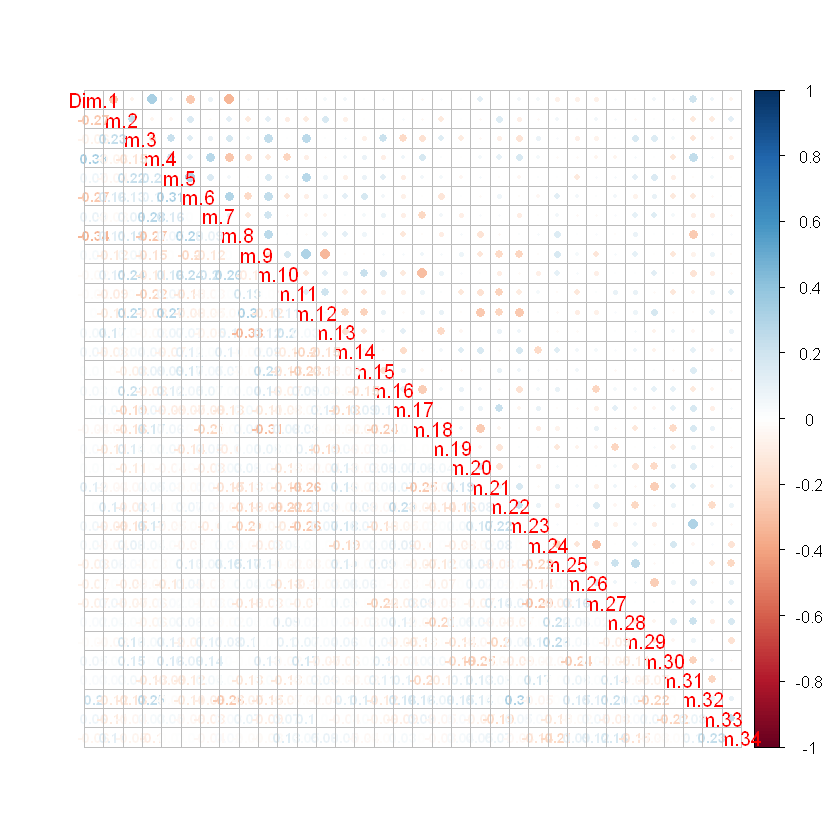

In [17]:
corrplot.mixed(cor(res.pca.poomeroy$ind$coord, method = "spearman"), number.cex = .7)

In [18]:
## Affichage des dimension de l'ACP réduite
print(dim(res.pca.poomeroy$ind$coord))

[1] 42 34


In [19]:
#### LDA
dis2 <- MASS::lda(class~., data=cbind(res.pca.poomeroy$ind$coord,data.frame(class=data_labels)))

In [20]:
dis2$counts

MD Mglio  Ncer  PNET  Rhab 
   10    10     4     8    10

In [21]:
## Pourcentage de discrimination de chaque axes
prop.lda = dis2$svd^2/sum(dis2$svd^2)
prop.lda*100

[1] 73.5101008 19.1682320  7.1278384  0.1938288

In [22]:
## Dimension de la LDA 
dim(dis2$scaling)

[1] 34  4

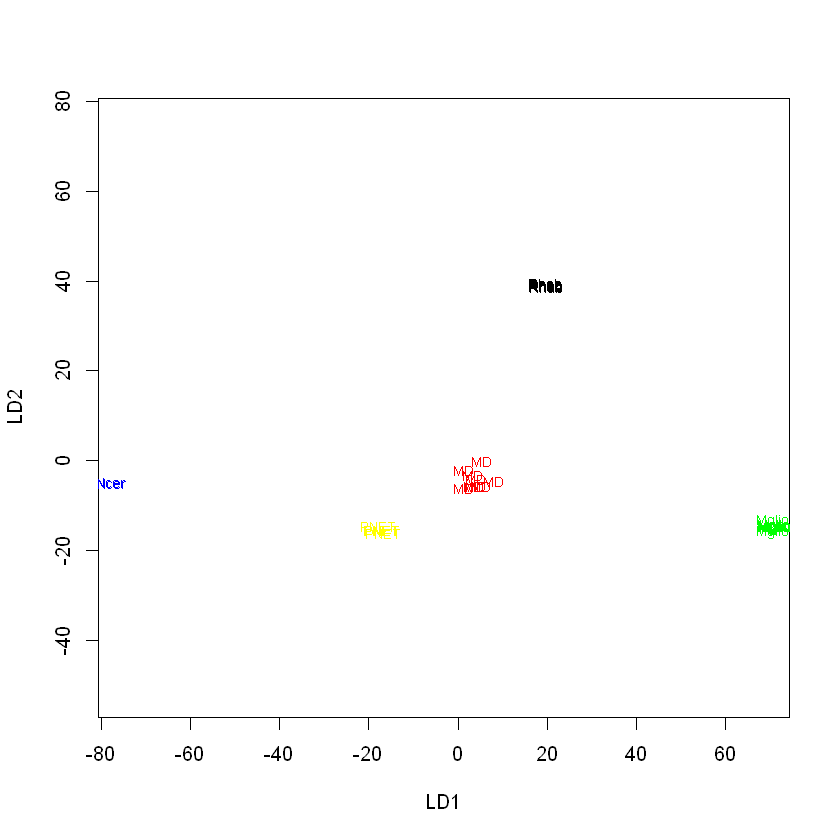

In [23]:
plot(dis2,col=c("red","green","blue","yellow")[as.numeric(data_labels)],dimen=2)

In [24]:
#Pomeroy MDS 
fit <- cmdscale( dist(x = data_raw,method = "euclidean"), k = 3,eig=TRUE)

In [25]:
### on affiche le GOF de la MDS Poomery
print(fit$GOF[1])

[1] 0.249264


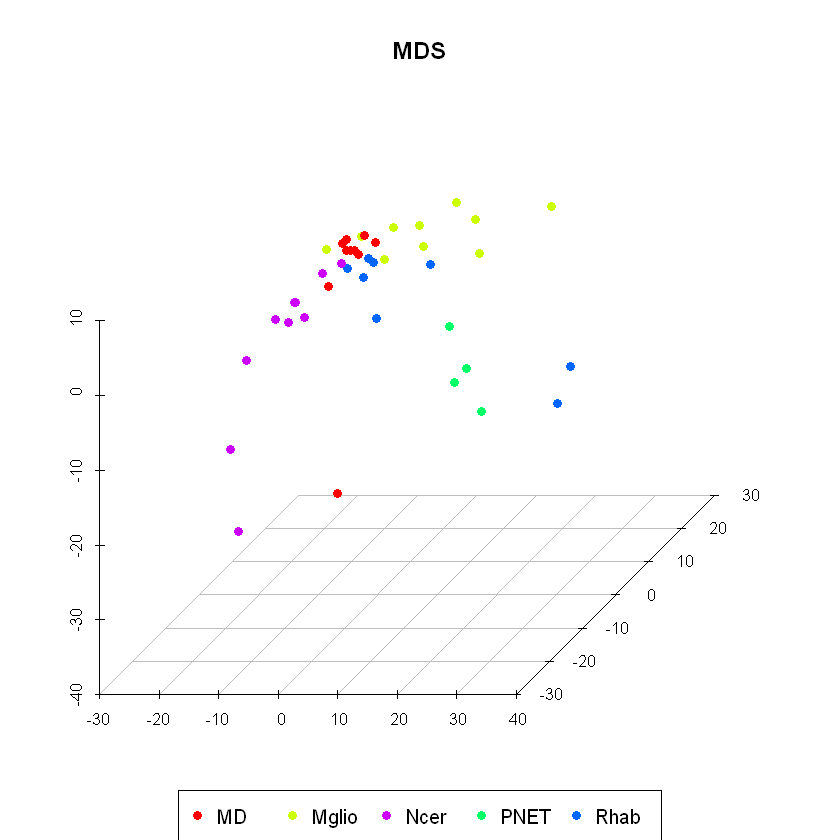

In [26]:
scatterplot3d(fit$points,pch = 16, color = colors[train.label],
              grid=TRUE, box=FALSE,main="MDS",xlab="",ylab="",zlab="")
legend("bottom", legend = levels(train.label),
      col =  unique(colors[train.label]), pch = 16, xpd = TRUE, horiz = TRUE,inset = -0.20)

In [27]:
data_lle_3d = LLE(data=data_raw, dim=3, k=41)

Computing distance matrix ... done
Computing low dimensional emmbedding (using 41 nearest neighbours)... done


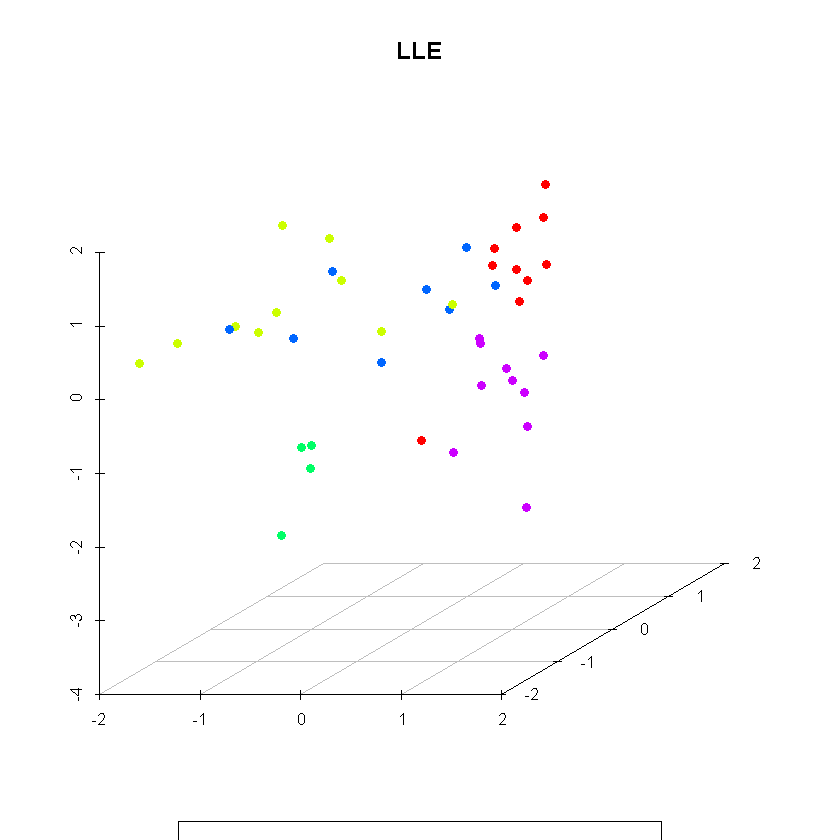

In [28]:
scatterplot3d(data_lle_3d,pch = 16, color = colors[train.label],
              grid=TRUE, box=FALSE,main="LLE",xlab="",ylab="",zlab="")
legend("bottom", legend = levels(train.label),
      col =  unique(colors[train.label]), pch = 16, xpd = TRUE, horiz = TRUE,inset = -0.25)

Computing distance matrix ... done
Building graph with shortest paths (using 20 nearest and 21 farthest neighbours) ... done
Computing low dimensional embedding ... done


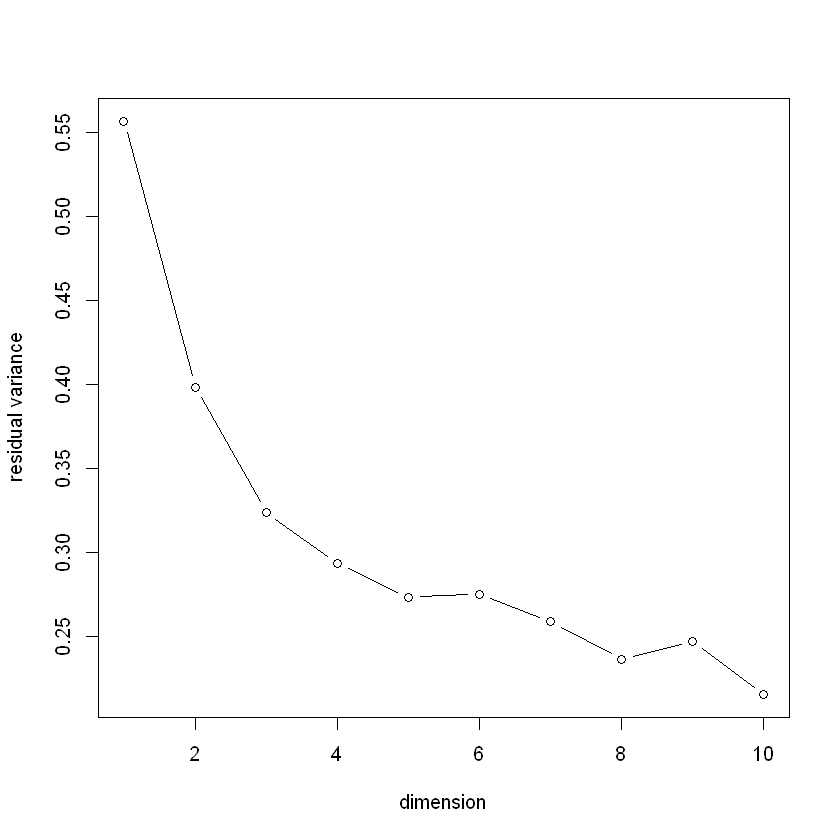

In [29]:
data_dim1to10_ISOMAP = Isomap(data=res.pca.poomeroy$ind$coord, dims=1:10, k=41, plotResiduals=TRUE,verbose =FALSE,mod=TRUE)

In [30]:
data_isomap_3d = Isomap(data=data_raw,dims=3, k=40,mod=FALSE)

Computing distance matrix ... done
Building graph with shortest paths (using 40 nearest neighbours) ... done
Computing low dimensional embedding ... done
number of samples: 42
reduction from 1378 to 3 dimensions
number of connected components in graph: 1


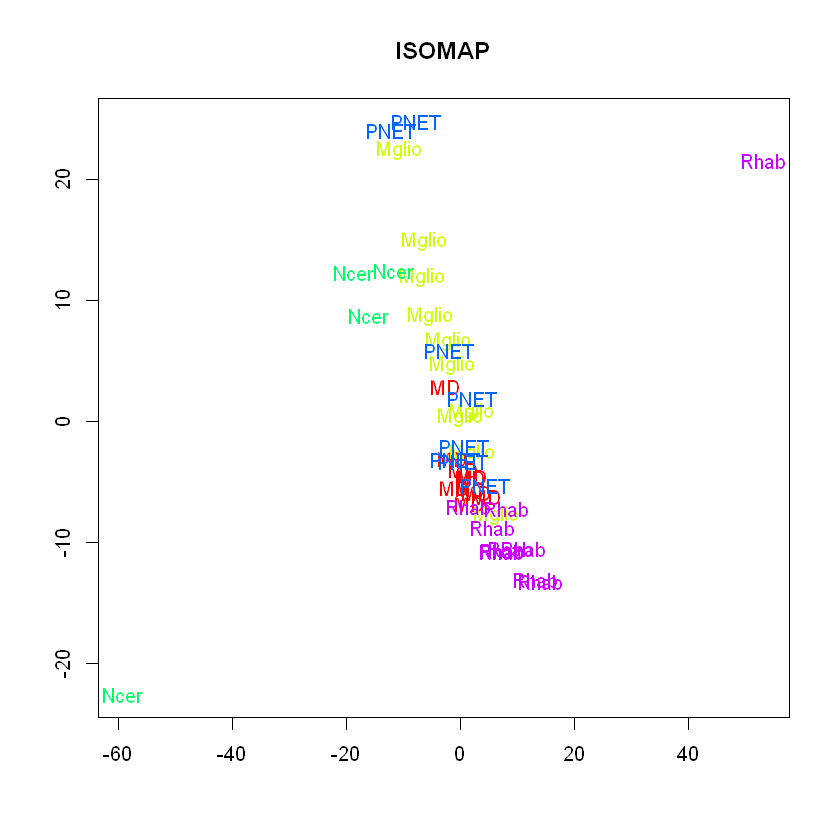

In [31]:
plot(data_isomap_3d$dim3,t='n', main="ISOMAP",xlab="",ylab="")
text(data_isomap_3d$dim3, labels = train.label,col=colors[train.label])

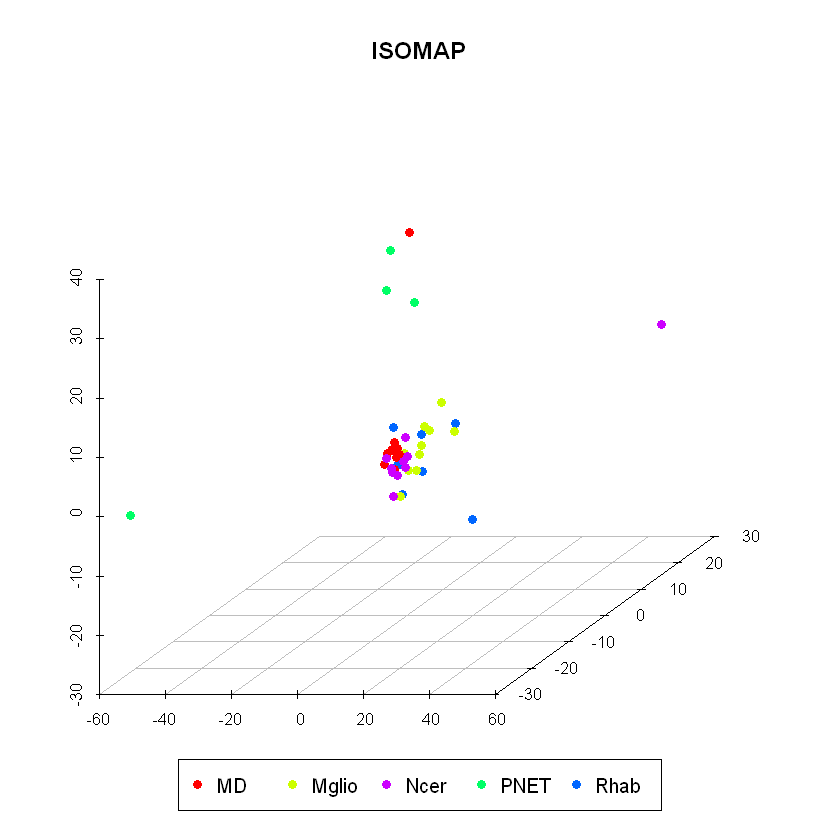

In [32]:
scatterplot3d(data_isomap_3d$dim3,pch = 16, color = colors[train.label],
              grid=TRUE, box=FALSE,main="ISOMAP",xlab="",ylab="",zlab="")
legend("bottom", legend = levels(train.label),
      col =  unique(colors[train.label]), pch = 16, xpd = TRUE, horiz = TRUE,inset = -0.15)

### Analyse sur Gordon

In [61]:
rawdata= read.csv2("gordon-2002_database.txt",sep="\t",header = TRUE,row.names = 1)
data= read.csv2("gordon-2002_database.txt",sep="\t",header = FALSE,row.names = 1,skip = 2,dec=".")
classes=read.csv2("gordon-2002_database.txt",sep="\t",header = TRUE,nrows = 1)[-1]
classes=t(classes)
data=t(data)
data=data.frame(classes,data,row.names = colnames(raw))
data_raw = scale(data[,-1],center = TRUE,scale=TRUE)
data_labels=data[,1]
train.label = as.factor(data_labels)
colors = rainbow(length(unique(train.label)))

In [62]:
print(dim(data))

[1]  181 1627


In [63]:
res.pca.gordon = FactoMineR::PCA(data_raw,ncp = Inf)

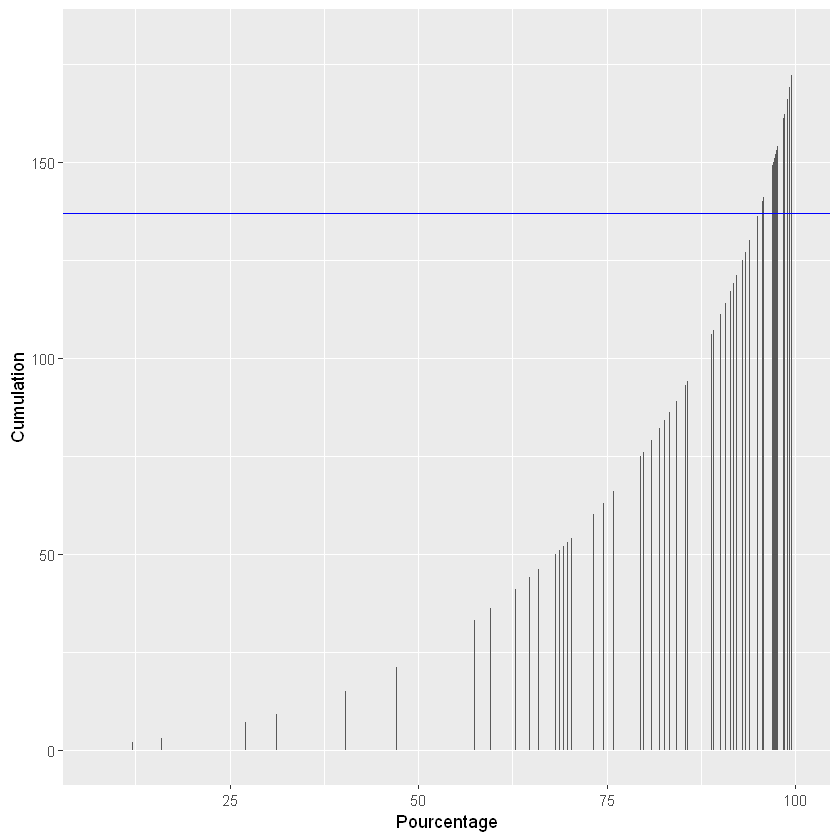

In [64]:
data.frame(Pourcentage=res.pca.gordon$eig[,3],Cumulation=1:180) %>% ggplot(aes(x=Pourcentage,y=Cumulation)) + geom_bar(stat = "identity") + geom_hline(yintercept = 137,color="blue")

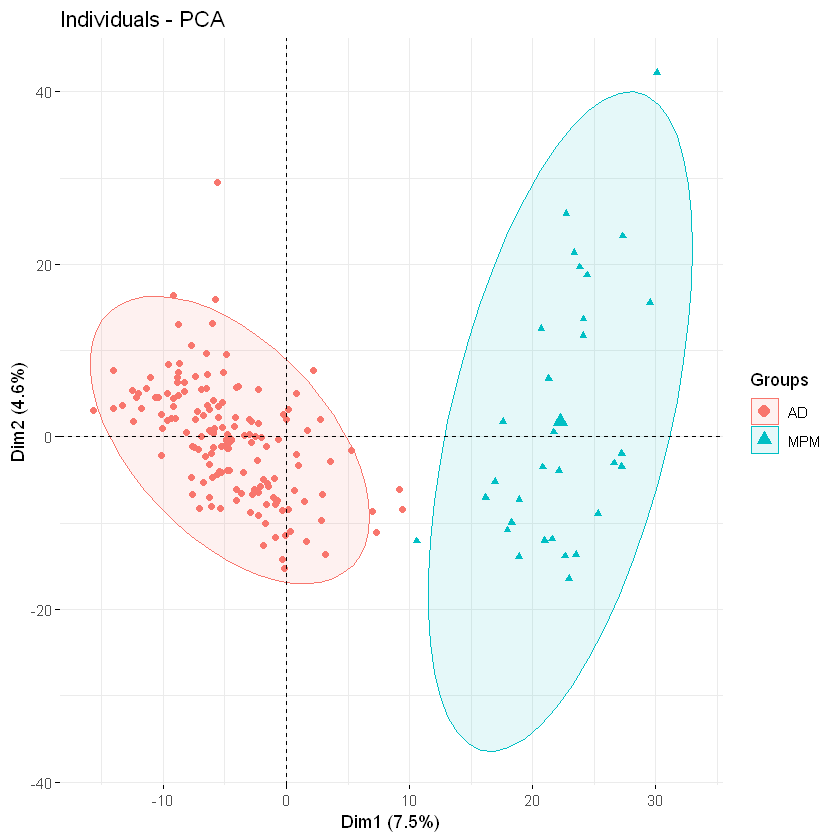

In [67]:
fviz_pca_ind(res.pca.gordon,
             geom.ind = "point", # Montre les points seulement (mais pas le "text")
             col.ind = classes, # colorer by groups
             #palette = c("#00AFBB", "#E7B800", "#FC4E07","#f698db","#322c61","#1d2e36"),
             addEllipses = TRUE, # Ellipses de concentration
             legend.title = "Groups"
             )

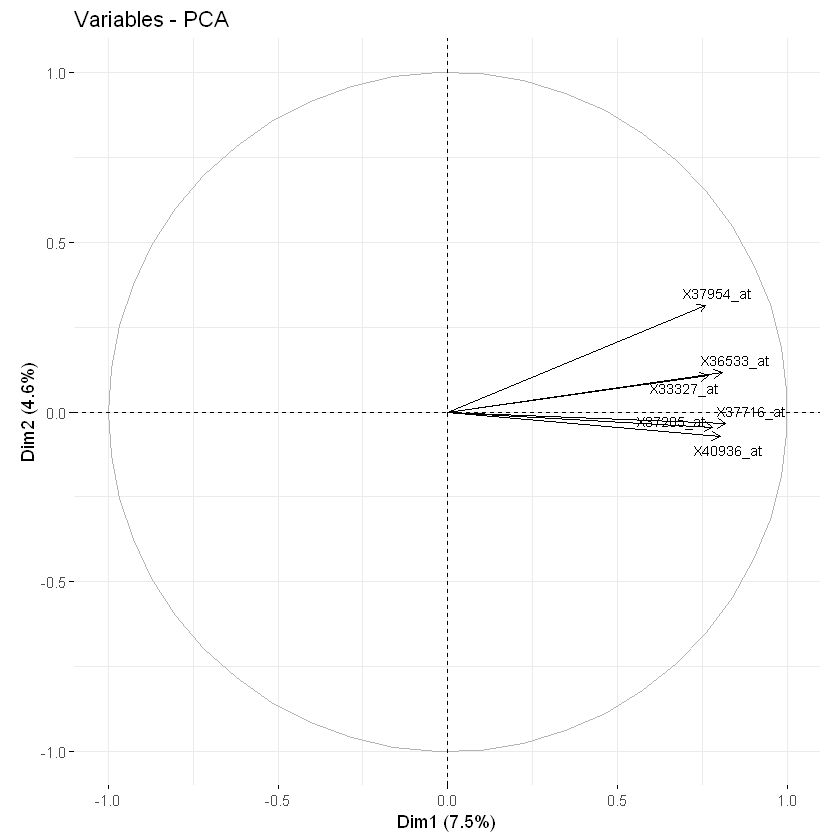

In [68]:
# Cercle de corrélation
fviz_pca_var(res.pca.gordon, select.var = list(cos2=0.6), repel=T,labelsize=3)

In [69]:
dl=apply(res.pca.gordon$var$cos2[,c(1,2)],1,sum)
names_0.8 = names(dl[dl>0.6])

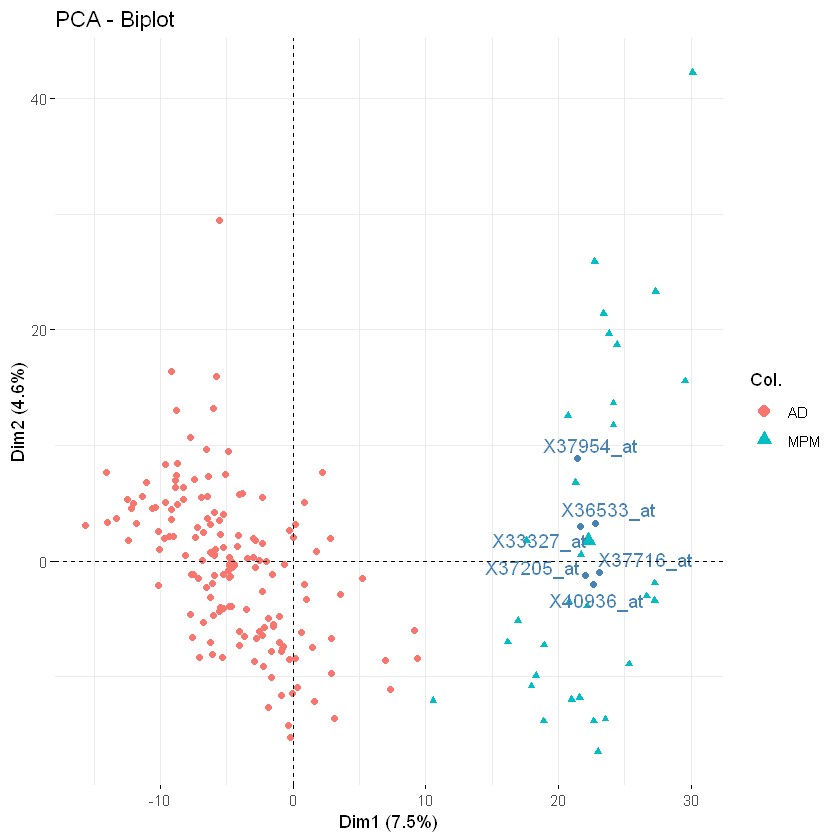

In [70]:
fviz_pca_biplot(res.pca.gordon,
                select.var=list(cos2=0.6),
                geom.ind = c("point"),
                geom.var = c("point","text"),
                repel=T,
                col.ind = classes)

In [71]:
### PCA sur les 137 premières composantes
res.pca.gordon = FactoMineR::PCA(data_raw,ncp = 137)

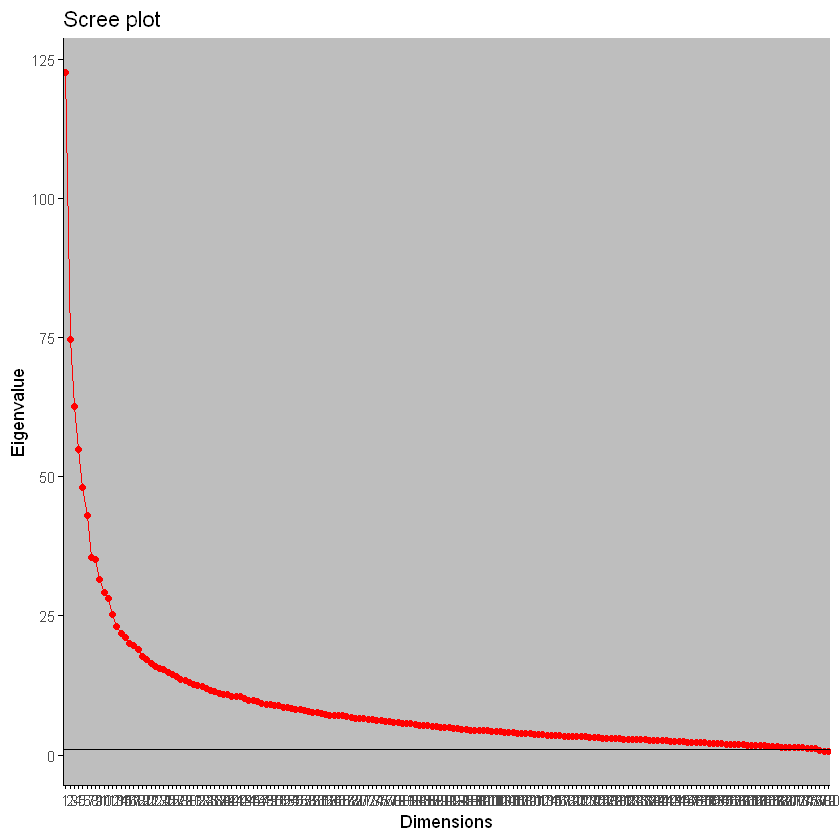

In [73]:
fviz_eig(res.pca.gordon,addlabels = FALSE,choice = "eigenvalue",ncp = Inf,geom = c("line"), linecolor = "red",ggtheme = theme(panel.background = element_rect(fill = 'grey', size = 1),panel.grid.major = element_blank(),panel.grid.minor = element_blank(),axis.line = element_line(size = 0.1, linetype = "solid",colour = "black"))) + geom_abline(slope=0,intercept = 1) 

In [82]:
dis2 <- lda(res.pca.gordon$ind$coord, data_labels)

In [83]:
## Proportion des classes
print(dis2$prior)

       AD       MPM 
0.8287293 0.1712707 


In [84]:
## Count Gordon
print(dis2$counts)

 AD MPM 
150  31 


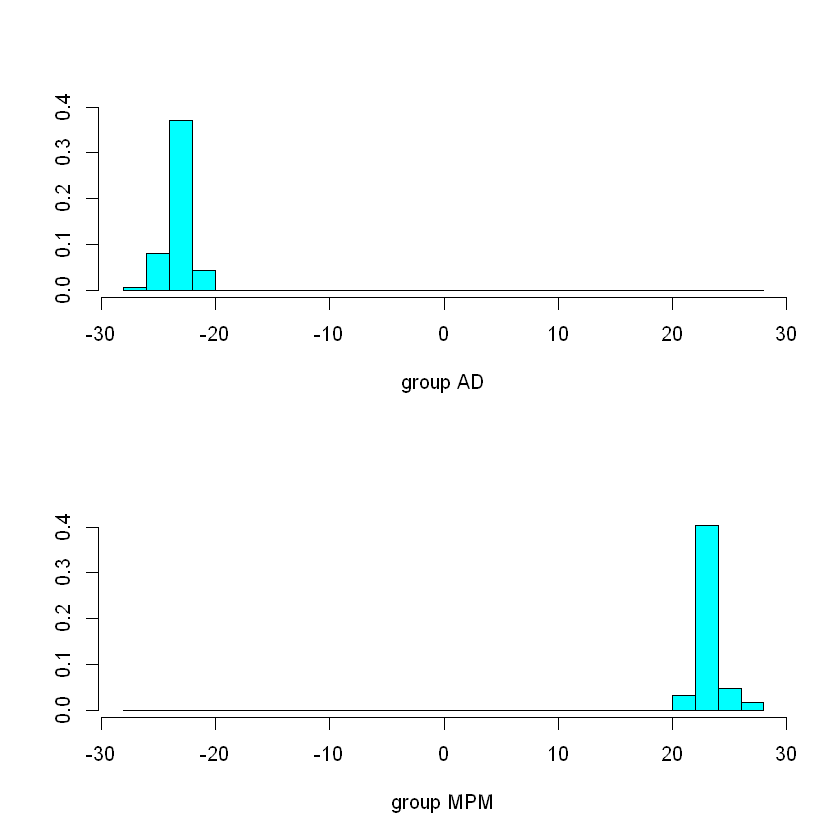

In [85]:
# Séparation linéaire 
plot(dis2)

In [47]:
## Pourcentage de discrimination de chaque axes
prop.lda = dis2$svd^2/sum(dis2$svd^2)
prop.lda*100

[1] 100

In [48]:
### MDS Gordon
fit <- cmdscale( dist(x = data_raw,method = "euclidean"), k = 2,eig = TRUE)

In [49]:
# GOF de la MDS sur Gordon
print(fit$GOF[1])

[1] 0.1213076


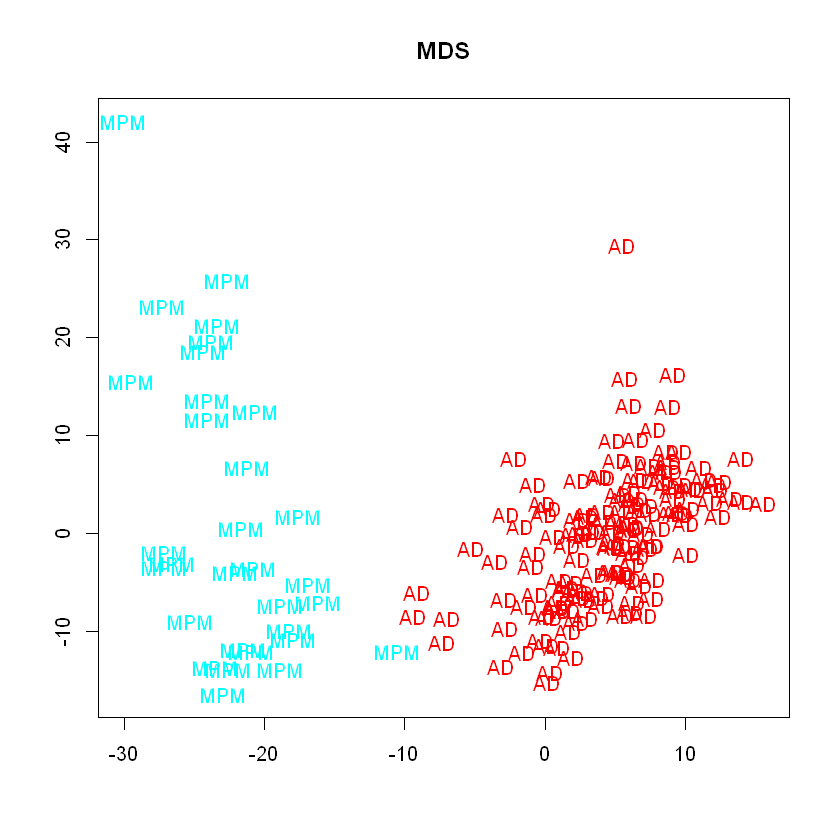

In [50]:
plot(fit$points,t='n', main="MDS",xlab="",ylab="")
text(fit$points, labels = train.label,col=colors[train.label])

Computing distance matrix ... done
Computing low dimensional emmbedding (using 180 nearest neighbours)... done


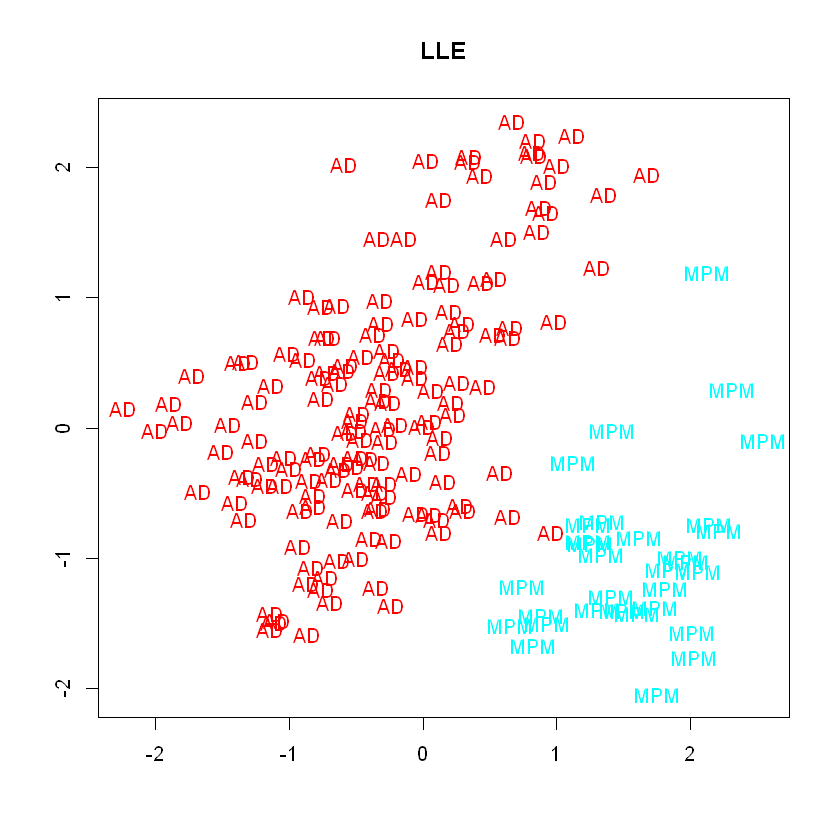

In [51]:
### LLE 2D 180 voisins
data_lle_2d = LLE(data=data_raw, dim=2, k=180)
plot(data_lle_2d,t='n', main="LLE",xlab="",ylab="")
text(data_lle_2d, labels = classes,col=colors[train.label])

Computing distance matrix ... done
Building graph with shortest paths (using 179 nearest neighbours) ... done
Computing low dimensional embedding ... done
Warning message in if (verbose == TRUE) {:
"la condition a une longueur > 1 et seul le premier élément est utilisé"number of samples: 181
reduction from 1626 to 12345678910 dimensions
number of connected components in graph: 1


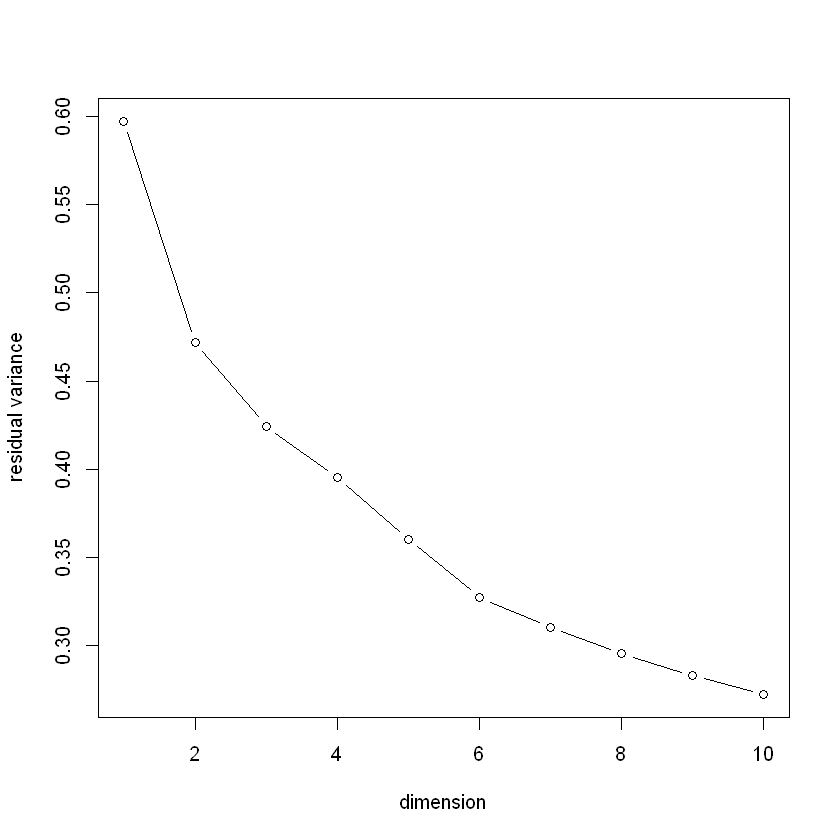

In [52]:
## ISOMAP Plot Residual 1:10
### Coude k=2
data_dim1to10_ISOMAP = Isomap(data=data_raw, dims=1:10, k=179, plotResiduals=TRUE,verbose =F,mod=FALSE)

In [53]:
data_isomap_2d = Isomap(data=data_raw, dims=2, k=179,mod=FALSE)

Computing distance matrix ... done
Building graph with shortest paths (using 179 nearest neighbours) ... done
Computing low dimensional embedding ... done
number of samples: 181
reduction from 1626 to 2 dimensions
number of connected components in graph: 1


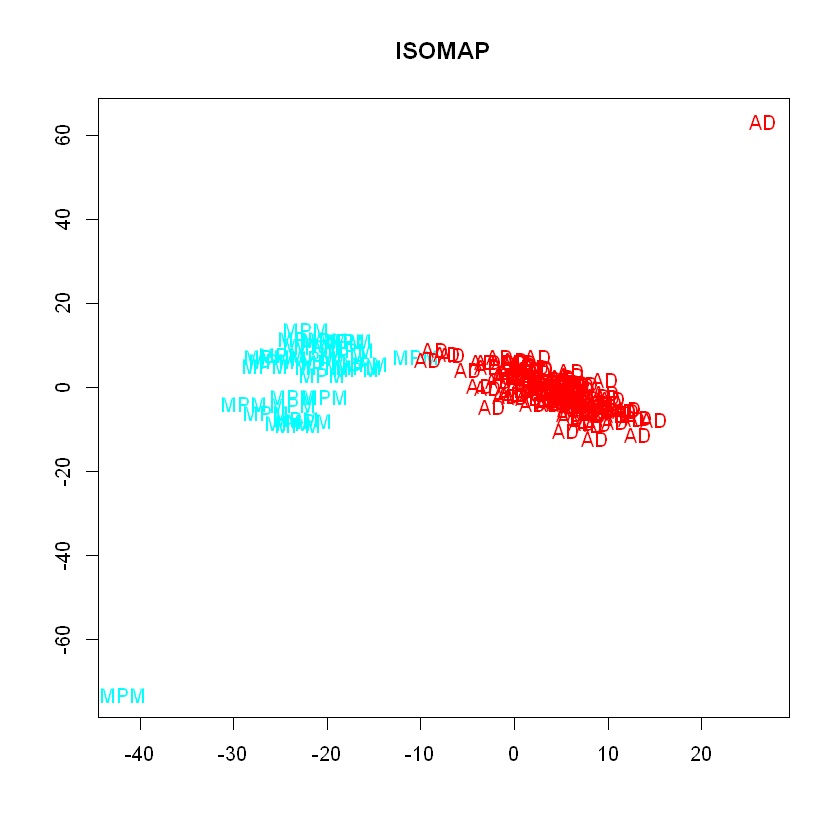

In [54]:
plot(data_isomap_2d$dim2,t='n', main="ISOMAP",xlab="",ylab="")
text(data_isomap_2d$dim2, labels = classes,col=colors[train.label])